In [219]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:2000].reshape(2000, 784)
x_test = x_test[2000:3000].reshape(1000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# we just pick 2000 instances in order to train the models faster
y_train = keras.utils.to_categorical(y_train[:2000], num_classes)
y_test = keras.utils.to_categorical(y_test[2000:3000], num_classes)

2000 train samples
1000 test samples


In [220]:
import numpy as np

In [221]:
from numpy.random import seed
seed(1)

In [222]:
def network(x_train, y_train, x_test, y_test, d_1, d_2, dr, if_dense3, d_3, act):
    model = '_'   # i do this to erase the data of previous models (just in case)
    model = Sequential()
    model.add(Dense(d_1, activation=act, input_shape=(784,)))
    model.add(Dropout(dr))
    model.add(Dense(d_2, activation=act))
    if if_dense3:                                 # should we add a third layer?
        model.add(Dense(d_3, activation=act))
    model.add(Dense(num_classes, activation='softmax'))    # we'll stay vanilla with that

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return float(score[0])    #this float is important

In [223]:
from nevergrad import instrumentation as instru

# argument transformation
first_dense_neurons = instru.variables.OrderedDiscrete([10, 20])  # neurons of the first dense layer
second_dense_neurons = instru.variables.OrderedDiscrete([10, 30])  # neurons of the second dense layer
dropout_rate = instru.variables.OrderedDiscrete([0.2, 0.6])  # dropout rate

third_dense = instru.variables.SoftmaxCategorical([False, True]) #Wether to add a third dense layer
third_dense_neurons = instru.variables.OrderedDiscrete([10, 50, 80]) #And its number of neurons if True

activation = instru.variables.SoftmaxCategorical(['relu', 'elu']) # Let's also play with the activation functions

# create the instrumented function
ifunc = instru.InstrumentedFunction(network, x_train, y_train, x_test, y_test,
                                    first_dense_neurons, second_dense_neurons, dropout_rate,
                                    third_dense, third_dense_neurons,
                                    activation)

print('Dimensiones: ', ifunc.dimension)  # 5 dimensional space

# The dimension is 5 because:
# - the 1st discrete variable has 1 possible values, represented by a hard thresholding in a 1-dimensional space, i.e. we add 1 coordinate to the continuous problem
# - the 2nd discrete variable has 3 possible values, represented by softmax, i.e. we add 3 coordinates to the continuous problem
# - the 3rd variable has no uncertainty, so it does not introduce any coordinate in the continuous problem
# - the 4th variable is a real number, represented by single coordinate.

#ifunc([1, -80])  # will print "b e blublu" and return 49 = (mean + std * arg)**2 = (1 + 2 * 3)**2
# b is selected because 1 > 0 (the threshold is 0 here since there are 2 values.
# e is selected because proba(e) = exp(80) / (exp(80) + exp(-80) + exp(-80))


Dimensiones:  8


In [207]:
?? instru.variables

In [244]:
from nevergrad.optimization import optimizerlib

optimizer = optimizerlib.CMA(dimension=ifunc.dimension, budget=200, num_workers=1)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=595728, Sat Dec 22 22:44:56 2018)


In [216]:
from concurrent import futures

with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
    recommendation = optimizer.optimize(ifunc, executor=executor, batch_mode=True, verbosity=2)

Launching 1 jobs with new suggestions
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 80)                880       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                810       
Total params: 9,650
Trainable params: 9,650
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 1000 samples
Epoch 1/2


InvalidArgumentError: Tensor dense_4_target:0, specified in either feed_devices or fetch_devices was not found in the Graph

In [245]:
history = []

for _ in range(optimizer.budget):
        print('\n\nGeneration: ', _)
        x = [0]*optimizer.num_workers
        for worker in range(optimizer.num_workers):
            x[worker] = optimizer.ask()
            print('X: ', x)
            value = ifunc(x[worker])
        history.append([_, x[worker], value])
        print('value: ', value)
        optimizer.tell(x[worker], value)
        print('optimizer: ', optimizer)

recommendation = optimizer.provide_recommendation()



Generation:  0
X:  [array([-0.09269268,  0.55326621, -0.42939344,  1.05164666,  0.51763137,
        0.64493807, -0.9906441 ,  1.58133418])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 9s 5ms/step - loss: 2.0470 - acc: 0.3365 - val_loss: 1.8599 - val_acc: 0.4850
Epoch 2/10
2000/2000 [==============================] - 0s 83us/step - loss: 1.6657 - acc: 0.5445 - val_loss: 1.5840 - val_acc: 0.5510
Epoch 3/10
2000/2000 [==============================] - 0s 76us/step - loss: 1.4185 - acc: 0.6110 - val_loss: 1.3759 - val_acc: 0.6030
Epoch 4/10
2000/2000 [==============================] - 0s 84us/step - loss: 1.2489 - acc: 0.6505 - val_loss: 1.2242 - val_acc: 0.6310
Epoch 5/10
2000/2000 [==============================] - 0s 73us/step - loss: 1.0706 - acc: 0.7195 - val_loss: 1.0789 - val_acc: 0.6910
Epoch 6/10
2000/2000 [==============================] - 0s 79us/step - loss: 0.9556 - acc: 0.7435 - val_loss: 0.9730 - val_acc: 0.7280
E

2000/2000 [==============================] - 0s 89us/step - loss: 0.8210 - acc: 0.7495 - val_loss: 0.7312 - val_acc: 0.7880
Test loss: 0.731190789937973
Test accuracy: 0.788
value:  0.731190789937973
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  5
X:  [array([ 1.81053031,  1.13430547,  0.47886339,  0.73525086,  0.47211186,
       -0.40755953,  0.57646331, -0.09720461])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 9s 4ms/step - loss: 2.2035 - acc: 0.1880 - val_loss: 2.0488 - val_acc: 0.4320
Epoch 2/10
2000/2000 [==============================] - 0s 84us/step - loss: 1.9482 - acc: 0.3265 - val_loss: 1.7605 - val_acc: 0.5120
Epoch 3/10
2000/2000 [==============================] - 0s 93us/step - loss: 1.7472 - acc: 0.3905 - val_loss: 1.5382 - val_acc: 0.5680
Epoch 4/10
2000/2000 [==============================] - 0s 88us/step - loss: 1.5844 - acc: 0.4460 - val_loss: 1.3804 - val_acc: 0.5750
Epo

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1b9d52400>>
Traceback (most recent call last):
  File "/Users/tfg/musicai/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Users/tfg/musicai/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 6346346896
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1ba27bc50>>
Traceback (most recent call last):
  File "/Users/tfg/musicai/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Users/tfg/musicai/lib/python3.6

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 11s 5ms/step - loss: 2.2002 - acc: 0.1615 - val_loss: 2.0424 - val_acc: 0.2970
Epoch 2/10
2000/2000 [==============================] - 0s 74us/step - loss: 2.0273 - acc: 0.2300 - val_loss: 1.9019 - val_acc: 0.3680
Epoch 3/10
2000/2000 [==============================] - 0s 81us/step - loss: 1.9271 - acc: 0.2705 - val_loss: 1.7959 - val_acc: 0.4220
Epoch 4/10
2000/2000 [==============================] - 0s 91us/step - loss: 1.8281 - acc: 0.3290 - val_loss: 1.7052 - val_acc: 0.4480
Epoch 5/10
2000/2000 [==============================] - 0s 99us/step - loss: 1.7275 - acc: 0.3535 - val_loss: 1.5983 - val_acc: 0.5050
Epoch 6/10
2000/2000 [==============================] - 0s 97us/step - loss: 1.6744 - acc: 0.3795 - val_loss: 1.5221 - val_acc: 0.5880
Epoch 7/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.5919 - acc: 0.4115 - val_loss: 1.4456 - val_acc: 0.5980
Epoch 8

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 8s 4ms/step - loss: 2.0812 - acc: 0.2805 - val_loss: 1.7847 - val_acc: 0.5630
Epoch 2/10
2000/2000 [==============================] - 0s 90us/step - loss: 1.6407 - acc: 0.5185 - val_loss: 1.4388 - val_acc: 0.6030
Epoch 3/10
2000/2000 [==============================] - 0s 91us/step - loss: 1.3872 - acc: 0.5610 - val_loss: 1.2057 - val_acc: 0.6660
Epoch 4/10
2000/2000 [==============================] - 0s 90us/step - loss: 1.1965 - acc: 0.6195 - val_loss: 1.0555 - val_acc: 0.6960
Epoch 5/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.1237 - acc: 0.6335 - val_loss: 0.9477 - val_acc: 0.7330
Epoch 6/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.0298 - acc: 0.6470 - val_loss: 0.8945 - val_acc: 0.7380
Epoch 7/10
2000/2000 [==============================] - 0s 84us/step - loss: 0.9752 - acc: 0.6650 - val_loss: 0.8318 - val_acc: 0.7670
Epoch 8/

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 8s 4ms/step - loss: 2.2373 - acc: 0.1485 - val_loss: 2.1203 - val_acc: 0.2260
Epoch 2/10
2000/2000 [==============================] - 0s 85us/step - loss: 2.1058 - acc: 0.2300 - val_loss: 2.0025 - val_acc: 0.2910
Epoch 3/10
2000/2000 [==============================] - 0s 84us/step - loss: 2.0087 - acc: 0.2620 - val_loss: 1.9146 - val_acc: 0.3480
Epoch 4/10
2000/2000 [==============================] - 0s 88us/step - loss: 1.9063 - acc: 0.2985 - val_loss: 1.8239 - val_acc: 0.3980
Epoch 5/10
2000/2000 [==============================] - 0s 92us/step - loss: 1.8242 - acc: 0.3435 - val_loss: 1.7228 - val_acc: 0.4220
Epoch 6/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.7244 - acc: 0.3650 - val_loss: 1.6532 - val_acc: 0.4500
Epoch 7/10
2000/2000 [==============================] - 0s 88us/step - loss: 1.6593 - acc: 0.3830 - val_loss: 1.5614 - val_acc: 0.4850
Epoch 8/

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 9s 4ms/step - loss: 2.1923 - acc: 0.1850 - val_loss: 2.0759 - val_acc: 0.3250
Epoch 2/10
2000/2000 [==============================] - 0s 82us/step - loss: 1.9707 - acc: 0.3220 - val_loss: 1.8474 - val_acc: 0.4130
Epoch 3/10
2000/2000 [==============================] - 0s 73us/step - loss: 1.7656 - acc: 0.3925 - val_loss: 1.6460 - val_acc: 0.5400
Epoch 4/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.5830 - acc: 0.4820 - val_loss: 1.4806 - val_acc: 0.5760
Epoch 5/10
2000/2000 [==============================] - 0s 87us/step - loss: 1.4680 - acc: 0.5435 - val_loss: 1.3649 - val_acc: 0.6230
Epoch 6/10
2000/2000 [==============================] - 0s 88us/step - loss: 1.3374 - acc: 0.5790 - val_loss: 1.2485 - val_acc: 0.6680
Epoch 7/10
2000/2000 [==============================] - 0s 85us/step - loss: 1.2387 - acc: 0.6025 - val_loss: 1.1644 - val_acc: 0.6770
Epoch 8/

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 9s 5ms/step - loss: 2.0062 - acc: 0.3580 - val_loss: 1.7415 - val_acc: 0.4820
Epoch 2/10
2000/2000 [==============================] - 0s 89us/step - loss: 1.5559 - acc: 0.5395 - val_loss: 1.4212 - val_acc: 0.5690
Epoch 3/10
2000/2000 [==============================] - 0s 97us/step - loss: 1.2603 - acc: 0.6280 - val_loss: 1.1738 - val_acc: 0.6730
Epoch 4/10
2000/2000 [==============================] - 0s 92us/step - loss: 1.0485 - acc: 0.6965 - val_loss: 1.0149 - val_acc: 0.7020
Epoch 5/10
2000/2000 [==============================] - 0s 93us/step - loss: 0.9090 - acc: 0.7295 - val_loss: 0.9096 - val_acc: 0.7220
Epoch 6/10
2000/2000 [==============================] - 0s 90us/step - loss: 0.8019 - acc: 0.7575 - val_loss: 0.8346 - val_acc: 0.7430
Epoch 7/10
2000/2000 [==============================] - 0s 88us/step - loss: 0.7278 - acc: 0.7885 - val_loss: 0.7818 - val_acc: 0.7630
Epoch 8/

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 9s 5ms/step - loss: 2.2543 - acc: 0.1830 - val_loss: 2.1652 - val_acc: 0.4140
Epoch 2/10
2000/2000 [==============================] - 0s 86us/step - loss: 2.1018 - acc: 0.2810 - val_loss: 1.9530 - val_acc: 0.4600
Epoch 3/10
2000/2000 [==============================] - 0s 89us/step - loss: 1.8943 - acc: 0.3615 - val_loss: 1.7195 - val_acc: 0.5610
Epoch 4/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.7357 - acc: 0.3975 - val_loss: 1.5332 - val_acc: 0.6140
Epoch 5/10
2000/2000 [==============================] - 0s 92us/step - loss: 1.5857 - acc: 0.4545 - val_loss: 1.3607 - val_acc: 0.6410
Epoch 6/10
2000/2000 [==============================] - 0s 88us/step - loss: 1.5026 - acc: 0.4840 - val_loss: 1.2551 - val_acc: 0.6960
Epoch 7/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.3843 - acc: 0.5145 - val_loss: 1.1669 - val_acc: 0.7010
Epoch 8/

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 10s 5ms/step - loss: 2.2525 - acc: 0.1530 - val_loss: 2.1836 - val_acc: 0.3220
Epoch 2/10
2000/2000 [==============================] - 0s 96us/step - loss: 2.1018 - acc: 0.2730 - val_loss: 2.0102 - val_acc: 0.3940
Epoch 3/10
2000/2000 [==============================] - 0s 102us/step - loss: 1.9409 - acc: 0.3265 - val_loss: 1.8286 - val_acc: 0.4700
Epoch 4/10
2000/2000 [==============================] - 0s 90us/step - loss: 1.7992 - acc: 0.3690 - val_loss: 1.6754 - val_acc: 0.5510
Epoch 5/10
2000/2000 [==============================] - 0s 97us/step - loss: 1.7008 - acc: 0.4000 - val_loss: 1.5387 - val_acc: 0.6130
Epoch 6/10
2000/2000 [==============================] - 0s 101us/step - loss: 1.5653 - acc: 0.4475 - val_loss: 1.4257 - val_acc: 0.6400
Epoch 7/10
2000/2000 [==============================] - 0s 91us/step - loss: 1.4916 - acc: 0.4780 - val_loss: 1.3002 - val_acc: 0.6830
Epoch

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 10s 5ms/step - loss: 2.1465 - acc: 0.2380 - val_loss: 1.9429 - val_acc: 0.5030
Epoch 2/10
2000/2000 [==============================] - 0s 91us/step - loss: 1.8877 - acc: 0.3695 - val_loss: 1.7071 - val_acc: 0.5830
Epoch 3/10
2000/2000 [==============================] - 0s 92us/step - loss: 1.6924 - acc: 0.4525 - val_loss: 1.5265 - val_acc: 0.6020
Epoch 4/10
2000/2000 [==============================] - 0s 89us/step - loss: 1.5438 - acc: 0.4870 - val_loss: 1.3693 - val_acc: 0.6400
Epoch 5/10
2000/2000 [==============================] - 0s 86us/step - loss: 1.4590 - acc: 0.5085 - val_loss: 1.2572 - val_acc: 0.6680
Epoch 6/10
2000/2000 [==============================] - 0s 141us/step - loss: 1.3730 - acc: 0.5310 - val_loss: 1.1485 - val_acc: 0.7110
Epoch 7/10
2000/2000 [==============================] - 0s 107us/step - loss: 1.3165 - acc: 0.5375 - val_loss: 1.0829 - val_acc: 0.7120
Epoch

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 10s 5ms/step - loss: 1.9268 - acc: 0.3945 - val_loss: 1.6268 - val_acc: 0.5720
Epoch 2/10
2000/2000 [==============================] - 0s 98us/step - loss: 1.3735 - acc: 0.6285 - val_loss: 1.2442 - val_acc: 0.6590
Epoch 3/10
2000/2000 [==============================] - 0s 97us/step - loss: 1.0510 - acc: 0.7110 - val_loss: 1.0177 - val_acc: 0.7100
Epoch 4/10
2000/2000 [==============================] - 0s 100us/step - loss: 0.8583 - acc: 0.7555 - val_loss: 0.8902 - val_acc: 0.7470
Epoch 5/10
2000/2000 [==============================] - 0s 101us/step - loss: 0.7378 - acc: 0.7895 - val_loss: 0.8063 - val_acc: 0.7660
Epoch 6/10
2000/2000 [==============================] - 0s 96us/step - loss: 0.6766 - acc: 0.8025 - val_loss: 0.7513 - val_acc: 0.7890
Epoch 7/10
2000/2000 [==============================] - 0s 94us/step - loss: 0.5951 - acc: 0.8230 - val_loss: 0.7260 - val_acc: 0.7860
Epoch

Test loss: 0.6291264350414276
Test accuracy: 0.799
value:  0.6291264350414276
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  54
X:  [array([ 0.30782288, -1.20783141,  1.83223623, -2.22825622, -0.89864137,
        0.31439505, -1.10497313, -0.59833232])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 11s 5ms/step - loss: 2.2114 - acc: 0.1535 - val_loss: 2.0913 - val_acc: 0.2730
Epoch 2/10
2000/2000 [==============================] - 0s 95us/step - loss: 2.0360 - acc: 0.2365 - val_loss: 1.9418 - val_acc: 0.3880
Epoch 3/10
2000/2000 [==============================] - 0s 95us/step - loss: 1.9268 - acc: 0.2965 - val_loss: 1.8119 - val_acc: 0.4460
Epoch 4/10
2000/2000 [==============================] - 0s 93us/step - loss: 1.8223 - acc: 0.3615 - val_loss: 1.6878 - val_acc: 0.5150
Epoch 5/10
2000/2000 [==============================] - 0s 92us/step - loss: 1.7101 - acc: 0.4270 - val_loss: 1.5530 - val_

Epoch 9/10
2000/2000 [==============================] - 0s 102us/step - loss: 1.2897 - acc: 0.5380 - val_loss: 1.1143 - val_acc: 0.6590
Epoch 10/10
2000/2000 [==============================] - 0s 103us/step - loss: 1.2466 - acc: 0.5420 - val_loss: 1.0703 - val_acc: 0.6910
Test loss: 1.070279586791992
Test accuracy: 0.691
value:  1.070279586791992
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  59
X:  [array([ 2.92927544,  1.39946343,  1.26831072, -1.1650114 , -1.03427136,
        0.46308559, -1.61301813,  1.28855425])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 11s 5ms/step - loss: 1.9753 - acc: 0.3310 - val_loss: 1.6135 - val_acc: 0.5790
Epoch 2/10
2000/2000 [==============================] - 0s 105us/step - loss: 1.5079 - acc: 0.5350 - val_loss: 1.2632 - val_acc: 0.6660
Epoch 3/10
2000/2000 [==============================] - 0s 105us/step - loss: 1.2252 - acc: 0.6030 - val_loss: 1.0329 - v

Epoch 7/10
2000/2000 [==============================] - 0s 175us/step - loss: 0.9757 - acc: 0.6965 - val_loss: 0.8482 - val_acc: 0.7750
Epoch 8/10
2000/2000 [==============================] - 0s 167us/step - loss: 0.9126 - acc: 0.7175 - val_loss: 0.7919 - val_acc: 0.7770
Epoch 9/10
2000/2000 [==============================] - 0s 142us/step - loss: 0.9012 - acc: 0.7120 - val_loss: 0.7635 - val_acc: 0.7820
Epoch 10/10
2000/2000 [==============================] - 0s 154us/step - loss: 0.8266 - acc: 0.7430 - val_loss: 0.7251 - val_acc: 0.7840
Test loss: 0.7251115140914917
Test accuracy: 0.784
value:  0.7251115140914917
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  64
X:  [array([ 1.8120189 ,  1.00121784,  2.43912207, -3.38264472, -2.43364005,
        0.60231191, -1.49501729, -0.26454269])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 16s 8ms/step - loss: 2.0255 - acc: 0.3080 - val_loss: 1.6884 -

Epoch 5/10
2000/2000 [==============================] - 0s 99us/step - loss: 1.1368 - acc: 0.6460 - val_loss: 1.0049 - val_acc: 0.7400
Epoch 6/10
2000/2000 [==============================] - 0s 131us/step - loss: 1.0473 - acc: 0.6865 - val_loss: 0.9017 - val_acc: 0.7630
Epoch 7/10
2000/2000 [==============================] - 0s 170us/step - loss: 0.9797 - acc: 0.6915 - val_loss: 0.8403 - val_acc: 0.7640
Epoch 8/10
2000/2000 [==============================] - 0s 162us/step - loss: 0.9123 - acc: 0.7225 - val_loss: 0.8049 - val_acc: 0.7760
Epoch 9/10
2000/2000 [==============================] - 0s 156us/step - loss: 0.8703 - acc: 0.7270 - val_loss: 0.7553 - val_acc: 0.7870
Epoch 10/10
2000/2000 [==============================] - 0s 128us/step - loss: 0.8632 - acc: 0.7255 - val_loss: 0.7260 - val_acc: 0.7870
Test loss: 0.7259521913528443
Test accuracy: 0.787
value:  0.7259521913528443
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  69
X:  [array([ 2.26511

Epoch 3/10
2000/2000 [==============================] - 0s 105us/step - loss: 1.2183 - acc: 0.6160 - val_loss: 0.9914 - val_acc: 0.7370
Epoch 4/10
2000/2000 [==============================] - 0s 110us/step - loss: 1.0802 - acc: 0.6525 - val_loss: 0.8435 - val_acc: 0.7810
Epoch 5/10
2000/2000 [==============================] - 0s 115us/step - loss: 0.9416 - acc: 0.7005 - val_loss: 0.7656 - val_acc: 0.7650
Epoch 6/10
2000/2000 [==============================] - 0s 107us/step - loss: 0.8963 - acc: 0.6910 - val_loss: 0.7016 - val_acc: 0.8100
Epoch 7/10
2000/2000 [==============================] - 0s 112us/step - loss: 0.8049 - acc: 0.7345 - val_loss: 0.6727 - val_acc: 0.8130
Epoch 8/10
2000/2000 [==============================] - 0s 123us/step - loss: 0.7776 - acc: 0.7430 - val_loss: 0.6337 - val_acc: 0.8150
Epoch 9/10
2000/2000 [==============================] - 0s 108us/step - loss: 0.7587 - acc: 0.7580 - val_loss: 0.6208 - val_acc: 0.8230
Epoch 10/10
2000/2000 [=========================

2000/2000 [==============================] - 13s 6ms/step - loss: 1.8602 - acc: 0.4325 - val_loss: 1.5281 - val_acc: 0.5930
Epoch 2/10
2000/2000 [==============================] - 0s 128us/step - loss: 1.2002 - acc: 0.6765 - val_loss: 1.1307 - val_acc: 0.6920
Epoch 3/10
2000/2000 [==============================] - 0s 116us/step - loss: 0.8824 - acc: 0.7625 - val_loss: 0.9362 - val_acc: 0.7380
Epoch 4/10
2000/2000 [==============================] - 0s 168us/step - loss: 0.7083 - acc: 0.8030 - val_loss: 0.7643 - val_acc: 0.7940
Epoch 5/10
2000/2000 [==============================] - 0s 125us/step - loss: 0.5825 - acc: 0.8355 - val_loss: 0.6721 - val_acc: 0.8050
Epoch 6/10
2000/2000 [==============================] - 0s 128us/step - loss: 0.5177 - acc: 0.8500 - val_loss: 0.6303 - val_acc: 0.8050
Epoch 7/10
2000/2000 [==============================] - 0s 130us/step - loss: 0.4531 - acc: 0.8645 - val_loss: 0.5852 - val_acc: 0.8200
Epoch 8/10
2000/2000 [==============================] - 0s 1

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 16s 8ms/step - loss: 1.8357 - acc: 0.4395 - val_loss: 1.5261 - val_acc: 0.5650
Epoch 2/10
2000/2000 [==============================] - 0s 110us/step - loss: 1.2076 - acc: 0.6870 - val_loss: 1.0923 - val_acc: 0.7010
Epoch 3/10
2000/2000 [==============================] - 0s 107us/step - loss: 0.8565 - acc: 0.7730 - val_loss: 0.8419 - val_acc: 0.7670
Epoch 4/10
2000/2000 [==============================] - 0s 116us/step - loss: 0.6759 - acc: 0.8025 - val_loss: 0.7194 - val_acc: 0.7860
Epoch 5/10
2000/2000 [==============================] - 0s 109us/step - loss: 0.5641 - acc: 0.8415 - val_loss: 0.6375 - val_acc: 0.8100
Epoch 6/10
2000/2000 [==============================] - 0s 103us/step - loss: 0.4866 - acc: 0.8600 - val_loss: 0.6075 - val_acc: 0.8030
Epoch 7/10
2000/2000 [==============================] - 0s 112us/step - loss: 0.4407 - acc: 0.8715 - val_loss: 0.5563 - val_acc: 0.8170
E

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 13s 7ms/step - loss: 2.0514 - acc: 0.2985 - val_loss: 1.7774 - val_acc: 0.5140
Epoch 2/10
2000/2000 [==============================] - 0s 108us/step - loss: 1.6047 - acc: 0.4950 - val_loss: 1.4048 - val_acc: 0.6010
Epoch 3/10
2000/2000 [==============================] - 0s 112us/step - loss: 1.3435 - acc: 0.5625 - val_loss: 1.1935 - val_acc: 0.6770
Epoch 4/10
2000/2000 [==============================] - 0s 99us/step - loss: 1.1780 - acc: 0.6235 - val_loss: 1.0532 - val_acc: 0.6990
Epoch 5/10
2000/2000 [==============================] - 0s 115us/step - loss: 1.0516 - acc: 0.6555 - val_loss: 0.9415 - val_acc: 0.7370
Epoch 6/10
2000/2000 [==============================] - 0s 138us/step - loss: 0.9608 - acc: 0.6800 - val_loss: 0.8814 - val_acc: 0.7400
Epoch 7/10
2000/2000 [==============================] - 0s 113us/step - loss: 0.9146 - acc: 0.6965 - val_loss: 0.8366 - val_acc: 0.7480
Ep

Test loss: 0.5598447875976562
Test accuracy: 0.817
value:  0.5598447875976562
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  93
X:  [array([ 1.61522107, -0.70030627, -0.06818433, -0.84309862, -0.65305563,
        5.04614748, -3.86217265,  1.13554189])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 13s 7ms/step - loss: 1.9316 - acc: 0.4110 - val_loss: 1.6352 - val_acc: 0.5510
Epoch 2/10
2000/2000 [==============================] - 0s 106us/step - loss: 1.3639 - acc: 0.6120 - val_loss: 1.2766 - val_acc: 0.6420
Epoch 3/10
2000/2000 [==============================] - 0s 105us/step - loss: 1.0539 - acc: 0.7070 - val_loss: 1.0709 - val_acc: 0.6750
Epoch 4/10
2000/2000 [==============================] - 0s 105us/step - loss: 0.8754 - acc: 0.7565 - val_loss: 0.9146 - val_acc: 0.7140
Epoch 5/10
2000/2000 [==============================] - 0s 103us/step - loss: 0.7559 - acc: 0.7825 - val_loss: 0.8210 - 

Epoch 9/10
2000/2000 [==============================] - 0s 106us/step - loss: 0.4714 - acc: 0.8515 - val_loss: 0.6256 - val_acc: 0.8200
Epoch 10/10
2000/2000 [==============================] - 0s 108us/step - loss: 0.4462 - acc: 0.8680 - val_loss: 0.5861 - val_acc: 0.8230
Test loss: 0.5861439852714538
Test accuracy: 0.823
value:  0.5861439852714538
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  98
X:  [array([ 3.83407481, -0.70240054, -2.41195206, -3.32729097, -1.64067965,
        3.62694932, -1.48743622,  1.63364866])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 14s 7ms/step - loss: 1.8919 - acc: 0.3615 - val_loss: 1.6324 - val_acc: 0.5290
Epoch 2/10
2000/2000 [==============================] - 0s 115us/step - loss: 1.3623 - acc: 0.6130 - val_loss: 1.2746 - val_acc: 0.6260
Epoch 3/10
2000/2000 [==============================] - 0s 107us/step - loss: 1.0695 - acc: 0.6820 - val_loss: 1.0969 -

Epoch 7/10
2000/2000 [==============================] - 0s 103us/step - loss: 0.4431 - acc: 0.8695 - val_loss: 0.5667 - val_acc: 0.8210
Epoch 8/10
2000/2000 [==============================] - 0s 102us/step - loss: 0.3978 - acc: 0.8785 - val_loss: 0.5488 - val_acc: 0.8300
Epoch 9/10
2000/2000 [==============================] - 0s 104us/step - loss: 0.3629 - acc: 0.8970 - val_loss: 0.5212 - val_acc: 0.8400
Epoch 10/10
2000/2000 [==============================] - 0s 103us/step - loss: 0.3346 - acc: 0.9070 - val_loss: 0.5273 - val_acc: 0.8360
Test loss: 0.52726726603508
Test accuracy: 0.836
value:  0.52726726603508
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  103
X:  [array([ 6.21913248,  2.13389713, -0.78085445, -1.75754791,  2.81593603,
        3.62021828, -2.01543184,  1.86825632])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.8102 - acc: 0.4450 - val_loss: 1.4409 - va

Epoch 5/10
2000/2000 [==============================] - 0s 115us/step - loss: 0.5804 - acc: 0.8425 - val_loss: 0.6702 - val_acc: 0.7930
Epoch 6/10
2000/2000 [==============================] - 0s 118us/step - loss: 0.4982 - acc: 0.8570 - val_loss: 0.6277 - val_acc: 0.8040
Epoch 7/10
2000/2000 [==============================] - 0s 118us/step - loss: 0.4659 - acc: 0.8725 - val_loss: 0.5927 - val_acc: 0.8140
Epoch 8/10
2000/2000 [==============================] - 0s 117us/step - loss: 0.4059 - acc: 0.8815 - val_loss: 0.5995 - val_acc: 0.8190
Epoch 9/10
2000/2000 [==============================] - 0s 110us/step - loss: 0.4018 - acc: 0.8810 - val_loss: 0.5539 - val_acc: 0.8250
Epoch 10/10
2000/2000 [==============================] - 0s 111us/step - loss: 0.3771 - acc: 0.8825 - val_loss: 0.5316 - val_acc: 0.8250
Test loss: 0.5315847759246826
Test accuracy: 0.825
value:  0.5315847759246826
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  108
X:  [array([ 3.424

Epoch 3/10
2000/2000 [==============================] - 0s 106us/step - loss: 0.8354 - acc: 0.7755 - val_loss: 0.8310 - val_acc: 0.7540
Epoch 4/10
2000/2000 [==============================] - 0s 107us/step - loss: 0.6659 - acc: 0.8110 - val_loss: 0.7139 - val_acc: 0.7830
Epoch 5/10
2000/2000 [==============================] - 0s 110us/step - loss: 0.5673 - acc: 0.8395 - val_loss: 0.6484 - val_acc: 0.8040
Epoch 6/10
2000/2000 [==============================] - 0s 115us/step - loss: 0.4990 - acc: 0.8580 - val_loss: 0.6370 - val_acc: 0.8070
Epoch 7/10
2000/2000 [==============================] - 0s 108us/step - loss: 0.4485 - acc: 0.8765 - val_loss: 0.5737 - val_acc: 0.8250
Epoch 8/10
2000/2000 [==============================] - 0s 108us/step - loss: 0.4212 - acc: 0.8845 - val_loss: 0.5681 - val_acc: 0.8250
Epoch 9/10
2000/2000 [==============================] - 0s 116us/step - loss: 0.3871 - acc: 0.8815 - val_loss: 0.5377 - val_acc: 0.8380
Epoch 10/10
2000/2000 [=========================

2000/2000 [==============================] - 30s 15ms/step - loss: 1.8365 - acc: 0.4715 - val_loss: 1.4882 - val_acc: 0.6250
Epoch 2/10
2000/2000 [==============================] - 0s 123us/step - loss: 1.1463 - acc: 0.7180 - val_loss: 1.0661 - val_acc: 0.7160
Epoch 3/10
2000/2000 [==============================] - 0s 125us/step - loss: 0.8452 - acc: 0.7790 - val_loss: 0.8548 - val_acc: 0.7550
Epoch 4/10
2000/2000 [==============================] - 0s 118us/step - loss: 0.6535 - acc: 0.8195 - val_loss: 0.7197 - val_acc: 0.7950
Epoch 5/10
2000/2000 [==============================] - 0s 122us/step - loss: 0.5666 - acc: 0.8330 - val_loss: 0.6702 - val_acc: 0.8010
Epoch 6/10
2000/2000 [==============================] - 0s 127us/step - loss: 0.4964 - acc: 0.8650 - val_loss: 0.6261 - val_acc: 0.8000
Epoch 7/10
2000/2000 [==============================] - 0s 129us/step - loss: 0.4381 - acc: 0.8730 - val_loss: 0.5780 - val_acc: 0.8310
Epoch 8/10
2000/2000 [==============================] - 0s 

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 18s 9ms/step - loss: 1.8902 - acc: 0.4165 - val_loss: 1.5922 - val_acc: 0.5440
Epoch 2/10
2000/2000 [==============================] - 0s 115us/step - loss: 1.3226 - acc: 0.6410 - val_loss: 1.2121 - val_acc: 0.6560
Epoch 3/10
2000/2000 [==============================] - 0s 129us/step - loss: 1.0160 - acc: 0.7235 - val_loss: 0.9968 - val_acc: 0.7260
Epoch 4/10
2000/2000 [==============================] - 0s 116us/step - loss: 0.8456 - acc: 0.7630 - val_loss: 0.8720 - val_acc: 0.7520
Epoch 5/10
2000/2000 [==============================] - 0s 117us/step - loss: 0.7081 - acc: 0.7985 - val_loss: 0.7722 - val_acc: 0.7780
Epoch 6/10
2000/2000 [==============================] - 0s 128us/step - loss: 0.6242 - acc: 0.8315 - val_loss: 0.7087 - val_acc: 0.7860
Epoch 7/10
2000/2000 [==============================] - 0s 158us/step - loss: 0.5601 - acc: 0.8535 - val_loss: 0.6818 - val_acc: 0.7930
E

Test loss: 0.5907617163658142
Test accuracy: 0.814
value:  0.5907617163658142
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  127
X:  [array([ 6.36582162,  0.39449516, -3.24868479, -5.31907289, -1.18218184,
        6.30939312, -4.20020724,  1.70626313])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 22s 11ms/step - loss: 1.7389 - acc: 0.4710 - val_loss: 1.3865 - val_acc: 0.6130
Epoch 2/10
2000/2000 [==============================] - 0s 158us/step - loss: 1.1121 - acc: 0.6905 - val_loss: 1.0028 - val_acc: 0.7280
Epoch 3/10
2000/2000 [==============================] - 0s 124us/step - loss: 0.8223 - acc: 0.7750 - val_loss: 0.7789 - val_acc: 0.7950
Epoch 4/10
2000/2000 [==============================] - 0s 122us/step - loss: 0.6486 - acc: 0.8260 - val_loss: 0.6597 - val_acc: 0.8250
Epoch 5/10
2000/2000 [==============================] - 0s 115us/step - loss: 0.5418 - acc: 0.8505 - val_loss: 0.6079 

Epoch 9/10
2000/2000 [==============================] - 0s 138us/step - loss: 0.4862 - acc: 0.8550 - val_loss: 0.6281 - val_acc: 0.8070
Epoch 10/10
2000/2000 [==============================] - 0s 154us/step - loss: 0.4719 - acc: 0.8610 - val_loss: 0.6138 - val_acc: 0.8070
Test loss: 0.6138137512207031
Test accuracy: 0.807
value:  0.6138137512207031
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  132
X:  [array([ 9.61086907,  1.88530356, -1.75632364, -6.82201998, -0.77500139,
        6.40650459, -5.34875179,  2.66649627])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 29s 14ms/step - loss: 1.7997 - acc: 0.4515 - val_loss: 1.4558 - val_acc: 0.5890
Epoch 2/10
2000/2000 [==============================] - 0s 224us/step - loss: 1.1250 - acc: 0.7000 - val_loss: 1.0802 - val_acc: 0.6860
Epoch 3/10
2000/2000 [==============================] - 0s 132us/step - loss: 0.8472 - acc: 0.7640 - val_loss: 0.8841

Epoch 7/10
2000/2000 [==============================] - 0s 136us/step - loss: 0.5743 - acc: 0.8530 - val_loss: 0.6871 - val_acc: 0.7980
Epoch 8/10
2000/2000 [==============================] - ETA: 0s - loss: 0.5208 - acc: 0.862 - 0s 132us/step - loss: 0.5191 - acc: 0.8625 - val_loss: 0.6465 - val_acc: 0.8140
Epoch 9/10
2000/2000 [==============================] - 0s 147us/step - loss: 0.4739 - acc: 0.8680 - val_loss: 0.6144 - val_acc: 0.8190
Epoch 10/10
2000/2000 [==============================] - 0s 132us/step - loss: 0.4458 - acc: 0.8735 - val_loss: 0.5868 - val_acc: 0.8290
Test loss: 0.5868436901569366
Test accuracy: 0.829
value:  0.5868436901569366
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  137
X:  [array([ 8.02868695,  2.38846659, -4.95172512, -8.42715683,  0.96871073,
        7.74187157, -3.79297271,  1.2791495 ])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 18s 9ms/step - loss: 1.

2000/2000 [==============================] - 0s 134us/step - loss: 0.6569 - acc: 0.8170 - val_loss: 0.7132 - val_acc: 0.7940
Epoch 5/10
2000/2000 [==============================] - 0s 141us/step - loss: 0.5476 - acc: 0.8420 - val_loss: 0.6451 - val_acc: 0.8030
Epoch 6/10
2000/2000 [==============================] - 0s 133us/step - loss: 0.4796 - acc: 0.8565 - val_loss: 0.5963 - val_acc: 0.8230
Epoch 7/10
2000/2000 [==============================] - 0s 131us/step - loss: 0.4324 - acc: 0.8735 - val_loss: 0.5797 - val_acc: 0.8150
Epoch 8/10
2000/2000 [==============================] - 0s 147us/step - loss: 0.4017 - acc: 0.8820 - val_loss: 0.5333 - val_acc: 0.8410
Epoch 9/10
2000/2000 [==============================] - 0s 142us/step - loss: 0.3757 - acc: 0.8915 - val_loss: 0.5414 - val_acc: 0.8330
Epoch 10/10
2000/2000 [==============================] - 0s 138us/step - loss: 0.3434 - acc: 0.9040 - val_loss: 0.5154 - val_acc: 0.8500
Test loss: 0.5153992247581481
Test accuracy: 0.85
value:  

Epoch 2/10
2000/2000 [==============================] - 0s 132us/step - loss: 1.0512 - acc: 0.7330 - val_loss: 0.9754 - val_acc: 0.7240
Epoch 3/10
2000/2000 [==============================] - 0s 125us/step - loss: 0.7851 - acc: 0.7865 - val_loss: 0.8140 - val_acc: 0.7470
Epoch 4/10
2000/2000 [==============================] - 0s 131us/step - loss: 0.6447 - acc: 0.8225 - val_loss: 0.7111 - val_acc: 0.7940
Epoch 5/10
2000/2000 [==============================] - 0s 129us/step - loss: 0.5526 - acc: 0.8400 - val_loss: 0.6606 - val_acc: 0.8040
Epoch 6/10
2000/2000 [==============================] - 0s 132us/step - loss: 0.4993 - acc: 0.8485 - val_loss: 0.6214 - val_acc: 0.8100
Epoch 7/10
2000/2000 [==============================] - 0s 125us/step - loss: 0.4453 - acc: 0.8640 - val_loss: 0.5845 - val_acc: 0.8290
Epoch 8/10
2000/2000 [==============================] - 0s 124us/step - loss: 0.4110 - acc: 0.8745 - val_loss: 0.5436 - val_acc: 0.8430
Epoch 9/10
2000/2000 [==========================

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 19s 10ms/step - loss: 1.9158 - acc: 0.4390 - val_loss: 1.5565 - val_acc: 0.6120
Epoch 2/10
2000/2000 [==============================] - 0s 145us/step - loss: 1.2183 - acc: 0.7045 - val_loss: 1.0838 - val_acc: 0.7140
Epoch 3/10
2000/2000 [==============================] - 0s 163us/step - loss: 0.8673 - acc: 0.7785 - val_loss: 0.8490 - val_acc: 0.7650
Epoch 4/10
2000/2000 [==============================] - 0s 188us/step - loss: 0.6807 - acc: 0.8160 - val_loss: 0.7242 - val_acc: 0.8010
Epoch 5/10
2000/2000 [==============================] - 0s 158us/step - loss: 0.5661 - acc: 0.8400 - val_loss: 0.6381 - val_acc: 0.8140
Epoch 6/10
2000/2000 [==============================] - 0s 145us/step - loss: 0.4905 - acc: 0.8500 - val_loss: 0.5879 - val_acc: 0.8390
Epoch 7/10
2000/2000 [==============================] - 0s 163us/step - loss: 0.4559 - acc: 0.8680 - val_loss: 0.5660 - val_acc: 0.8480


Test loss: 0.5307364416122436
Test accuracy: 0.841
value:  0.5307364416122436
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  156
X:  [array([ 2.87329354,  2.64444414, -3.44977414, -2.87218803,  2.39001569,
        3.69531353, -0.85626327,  2.57116658])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 18s 9ms/step - loss: 1.8695 - acc: 0.4365 - val_loss: 1.4690 - val_acc: 0.6200
Epoch 2/10
2000/2000 [==============================] - 0s 134us/step - loss: 1.1696 - acc: 0.7030 - val_loss: 1.0334 - val_acc: 0.7130
Epoch 3/10
2000/2000 [==============================] - 0s 133us/step - loss: 0.8240 - acc: 0.7785 - val_loss: 0.8512 - val_acc: 0.7400
Epoch 4/10
2000/2000 [==============================] - 0s 131us/step - loss: 0.6591 - acc: 0.8165 - val_loss: 0.7091 - val_acc: 0.7820
Epoch 5/10
2000/2000 [==============================] - 0s 137us/step - loss: 0.5539 - acc: 0.8440 - val_loss: 0.6570 -

Epoch 9/10
2000/2000 [==============================] - 0s 130us/step - loss: 0.3900 - acc: 0.8830 - val_loss: 0.5375 - val_acc: 0.8350
Epoch 10/10
2000/2000 [==============================] - 0s 128us/step - loss: 0.3677 - acc: 0.8955 - val_loss: 0.5282 - val_acc: 0.8410
Test loss: 0.5281991305351257
Test accuracy: 0.841
value:  0.5281991305351257
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  161
X:  [array([ 7.67529805,  1.16924067, -3.63040356, -5.09536287,  4.53254312,
        6.87307463, -4.09089761,  1.47745163])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 17s 9ms/step - loss: 1.6773 - acc: 0.5215 - val_loss: 1.3349 - val_acc: 0.6180
Epoch 2/10
2000/2000 [==============================] - 0s 133us/step - loss: 1.0479 - acc: 0.7415 - val_loss: 1.0218 - val_acc: 0.6930
Epoch 3/10
2000/2000 [==============================] - 0s 137us/step - loss: 0.7832 - acc: 0.7880 - val_loss: 0.8252 

Epoch 7/10
2000/2000 [==============================] - 0s 142us/step - loss: 0.4393 - acc: 0.8665 - val_loss: 0.5527 - val_acc: 0.8430
Epoch 8/10
2000/2000 [==============================] - 0s 130us/step - loss: 0.4058 - acc: 0.8770 - val_loss: 0.5539 - val_acc: 0.8340
Epoch 9/10
2000/2000 [==============================] - 0s 137us/step - loss: 0.3681 - acc: 0.8910 - val_loss: 0.5505 - val_acc: 0.8340
Epoch 10/10
2000/2000 [==============================] - 0s 130us/step - loss: 0.3496 - acc: 0.9060 - val_loss: 0.5288 - val_acc: 0.8520
Test loss: 0.5287870609760285
Test accuracy: 0.852
value:  0.5287870609760285
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  166
X:  [array([ 5.70304827,  0.90250407, -6.33163785, -4.47332536,  4.06477968,
        7.02878138, -3.28518574,  3.28160134])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 17s 9ms/step - loss: 1.7728 - acc: 0.4910 - val_loss: 1.4326 

Epoch 5/10
2000/2000 [==============================] - 0s 242us/step - loss: 0.5800 - acc: 0.8350 - val_loss: 0.6684 - val_acc: 0.8100
Epoch 6/10
2000/2000 [==============================] - 1s 250us/step - loss: 0.5137 - acc: 0.8545 - val_loss: 0.6242 - val_acc: 0.8060
Epoch 7/10
2000/2000 [==============================] - 0s 234us/step - loss: 0.4549 - acc: 0.8650 - val_loss: 0.5753 - val_acc: 0.8320
Epoch 8/10
2000/2000 [==============================] - 1s 405us/step - loss: 0.4203 - acc: 0.8740 - val_loss: 0.5648 - val_acc: 0.8370
Epoch 9/10
2000/2000 [==============================] - 1s 269us/step - loss: 0.3922 - acc: 0.8845 - val_loss: 0.5467 - val_acc: 0.8360
Epoch 10/10
2000/2000 [==============================] - 0s 226us/step - loss: 0.3656 - acc: 0.8885 - val_loss: 0.5412 - val_acc: 0.8320
Test loss: 0.5411638760566712
Test accuracy: 0.832
value:  0.5411638760566712
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  171
X:  [array([ 6.909

Epoch 3/10
2000/2000 [==============================] - 0s 143us/step - loss: 0.8635 - acc: 0.7585 - val_loss: 0.8824 - val_acc: 0.7370
Epoch 4/10
2000/2000 [==============================] - 0s 140us/step - loss: 0.6873 - acc: 0.8055 - val_loss: 0.7566 - val_acc: 0.7720
Epoch 5/10
2000/2000 [==============================] - 0s 139us/step - loss: 0.5881 - acc: 0.8380 - val_loss: 0.6903 - val_acc: 0.7960
Epoch 6/10
2000/2000 [==============================] - 0s 148us/step - loss: 0.5176 - acc: 0.8375 - val_loss: 0.6071 - val_acc: 0.8170
Epoch 7/10
2000/2000 [==============================] - 0s 140us/step - loss: 0.4630 - acc: 0.8635 - val_loss: 0.6144 - val_acc: 0.8080
Epoch 8/10
2000/2000 [==============================] - 0s 144us/step - loss: 0.4061 - acc: 0.8810 - val_loss: 0.5709 - val_acc: 0.8280
Epoch 9/10
2000/2000 [==============================] - 0s 150us/step - loss: 0.3936 - acc: 0.8820 - val_loss: 0.5389 - val_acc: 0.8450
Epoch 10/10
2000/2000 [=========================

2000/2000 [==============================] - 18s 9ms/step - loss: 1.8024 - acc: 0.4395 - val_loss: 1.4086 - val_acc: 0.6310
Epoch 2/10
2000/2000 [==============================] - 0s 145us/step - loss: 1.1468 - acc: 0.6795 - val_loss: 1.0325 - val_acc: 0.7030
Epoch 3/10
2000/2000 [==============================] - 0s 139us/step - loss: 0.8513 - acc: 0.7545 - val_loss: 0.8372 - val_acc: 0.7550
Epoch 4/10
2000/2000 [==============================] - 0s 144us/step - loss: 0.6847 - acc: 0.7955 - val_loss: 0.7527 - val_acc: 0.7720
Epoch 5/10
2000/2000 [==============================] - 0s 141us/step - loss: 0.5708 - acc: 0.8325 - val_loss: 0.6755 - val_acc: 0.7880
Epoch 6/10
2000/2000 [==============================] - 0s 139us/step - loss: 0.5170 - acc: 0.8495 - val_loss: 0.6250 - val_acc: 0.8110
Epoch 7/10
2000/2000 [==============================] - 0s 142us/step - loss: 0.4586 - acc: 0.8675 - val_loss: 0.6047 - val_acc: 0.8090
Epoch 8/10
2000/2000 [==============================] - 0s 1

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 18s 9ms/step - loss: 1.7939 - acc: 0.4440 - val_loss: 1.4217 - val_acc: 0.6350
Epoch 2/10
2000/2000 [==============================] - 0s 162us/step - loss: 1.1303 - acc: 0.7035 - val_loss: 1.0237 - val_acc: 0.7260
Epoch 3/10
2000/2000 [==============================] - 0s 155us/step - loss: 0.8422 - acc: 0.7685 - val_loss: 0.8264 - val_acc: 0.7700
Epoch 4/10
2000/2000 [==============================] - 0s 150us/step - loss: 0.6717 - acc: 0.8155 - val_loss: 0.7247 - val_acc: 0.8000
Epoch 5/10
2000/2000 [==============================] - 0s 146us/step - loss: 0.5643 - acc: 0.8360 - val_loss: 0.6461 - val_acc: 0.8140
Epoch 6/10
2000/2000 [==============================] - 0s 146us/step - loss: 0.4990 - acc: 0.8465 - val_loss: 0.6089 - val_acc: 0.8150
Epoch 7/10
2000/2000 [==============================] - 0s 144us/step - loss: 0.4373 - acc: 0.8775 - val_loss: 0.5692 - val_acc: 0.8270
E

Test loss: 1.0385424294471741
Test accuracy: 0.728
value:  1.0385424294471741
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  190
X:  [array([ 5.06240774,  3.72857723,  0.97665849, -5.92371261,  4.01421968,
        3.59496782, -1.64649076,  3.3175075 ])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 18s 9ms/step - loss: 1.9948 - acc: 0.3160 - val_loss: 1.6216 - val_acc: 0.5840
Epoch 2/10
2000/2000 [==============================] - 0s 146us/step - loss: 1.5137 - acc: 0.5230 - val_loss: 1.2533 - val_acc: 0.6540
Epoch 3/10
2000/2000 [==============================] - 0s 145us/step - loss: 1.2560 - acc: 0.5970 - val_loss: 1.0357 - val_acc: 0.6860
Epoch 4/10
2000/2000 [==============================] - 0s 151us/step - loss: 1.0687 - acc: 0.6605 - val_loss: 0.8801 - val_acc: 0.7460
Epoch 5/10
2000/2000 [==============================] - 0s 145us/step - loss: 0.9771 - acc: 0.6630 - val_loss: 0.8111 -

Epoch 9/10
2000/2000 [==============================] - 0s 154us/step - loss: 0.3707 - acc: 0.8910 - val_loss: 0.5536 - val_acc: 0.8300
Epoch 10/10
2000/2000 [==============================] - 0s 156us/step - loss: 0.3533 - acc: 0.8890 - val_loss: 0.5512 - val_acc: 0.8350
Test loss: 0.5511936802864075
Test accuracy: 0.835
value:  0.5511936802864075
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


Generation:  195
X:  [array([ 5.80706103,  0.0808022 , -1.29529207, -2.7238266 ,  1.98591818,
        2.87513409, -2.5218143 ,  3.34025033])]
Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 20s 10ms/step - loss: 1.8034 - acc: 0.4805 - val_loss: 1.4663 - val_acc: 0.6330
Epoch 2/10
2000/2000 [==============================] - 0s 145us/step - loss: 1.1609 - acc: 0.6960 - val_loss: 1.0838 - val_acc: 0.6920
Epoch 3/10
2000/2000 [==============================] - 0s 151us/step - loss: 0.8653 - acc: 0.7610 - val_loss: 0.8712

Epoch 7/10
2000/2000 [==============================] - 0s 157us/step - loss: 0.4442 - acc: 0.8735 - val_loss: 0.5926 - val_acc: 0.8200
Epoch 8/10
2000/2000 [==============================] - 0s 143us/step - loss: 0.3984 - acc: 0.8865 - val_loss: 0.5521 - val_acc: 0.8300
Epoch 9/10
2000/2000 [==============================] - 0s 141us/step - loss: 0.3718 - acc: 0.8870 - val_loss: 0.5335 - val_acc: 0.8390
Epoch 10/10
2000/2000 [==============================] - 0s 144us/step - loss: 0.3484 - acc: 0.8995 - val_loss: 0.5398 - val_acc: 0.8400
Test loss: 0.5397809641361236
Test accuracy: 0.84
value:  0.5397809641361236
optimizer:  Instance of CMA(dimension=8, budget=200, num_workers=1)


In [246]:
history

[[0, array([-0.09269268,  0.55326621, -0.42939344,  1.05164666,  0.51763137,
          0.64493807, -0.9906441 ,  1.58133418]), 0.7328361854553223],
 [1, array([ 0.21298084, -0.64473395, -0.41387274, -2.02706103, -0.05518718,
          0.12452323,  0.92247129,  1.04696677]), 0.6340950512886048],
 [2, array([ 0.28965749,  0.15380109,  0.02414381, -0.21871814,  0.53369279,
          0.06990533, -0.28987532,  0.15773437]), 0.6551961889266967],
 [3, array([ 0.62385514, -1.09495526, -0.35331223,  0.2441219 ,  1.17612997,
         -0.37738797, -0.57284834, -0.87968619]), 0.9860171785354614],
 [4, array([ 0.5244142 ,  0.91928177,  1.12844669,  0.21487503, -0.36481139,
          0.55842785, -1.17821118, -0.11893813]), 0.731190789937973],
 [5, array([ 1.81053031,  1.13430547,  0.47886339,  0.73525086,  0.47211186,
         -0.40755953,  0.57646331, -0.09720461]), 0.9453985605239869],
 [6, array([ 0.27490747,  0.01745295, -0.24211933, -0.8499886 ,  1.07691014,
         -1.11389829,  0.95905237, -

In [323]:
x_scatter = []
y_scatter = []
s_scatter = []
ep_scatter = []
for h in history:
    l = []
    for p in range(len(h[1])):
        l.append(h[1][p])
    x_scatter.append(l)
    y_scatter.append(h[1][5])
    s_scatter.append(0.3*(1/h[2]**10))
    ep_scatter.append(0.4*h[0]/len(history))

In [314]:
x_scatter

[[-0.09269267946073871,
  0.5532662142692734,
  -0.42939343536016694,
  1.0516466577385795,
  0.5176313725747432,
  0.6449380740423029,
  -0.9906440976031698,
  1.58133417767476],
 [0.21298083746166782,
  -0.6447339494582586,
  -0.4138727386709791,
  -2.0270610312407817,
  -0.05518717979734703,
  0.12452323180356045,
  0.9224712933888561,
  1.04696676848476],
 [0.289657493702662,
  0.15380108552612265,
  0.024143811145826026,
  -0.2187181372204931,
  0.5336927850386093,
  0.06990533397699725,
  -0.28987531851597537,
  0.15773436503239138],
 [0.6238551409710681,
  -1.0949552622164933,
  -0.3533122285847599,
  0.24412189773722917,
  1.1761299741254005,
  -0.3773879727337709,
  -0.5728483414978918,
  -0.8796861873731107],
 [0.5244142018443648,
  0.9192817697552481,
  1.1284466943837266,
  0.21487503135238864,
  -0.36481139184093436,
  0.5584278544170115,
  -1.1782111779247255,
  -0.11893813354032053],
 [1.8105303132033974,
  1.1343054679642883,
  0.47886338978049714,
  0.7352508578046947,

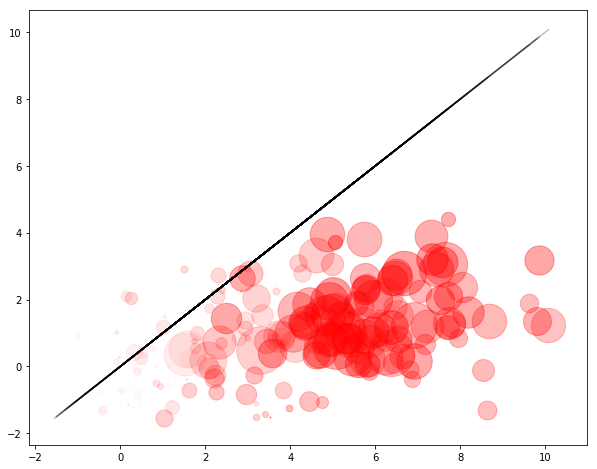

In [321]:
plt.figure(figsize=(10,8))
for i in range(len(ep_scatter)):
    plt.scatter(x_scatter[i][0], x_scatter[i][1], color='r', s=s_scatter[i], alpha = ep_scatter[i])
    if i < len(ep_scatter)-1:
        plt.plot([x_scatter[i-1][0]] + [x_scatter[i][1]], [x_scatter[i-1][0]] + [x_scatter[i][1]], color='black', alpha=0.4*i/len(ep_scatter))

plt.show()


In [349]:

nrows = 3
ncols = 3



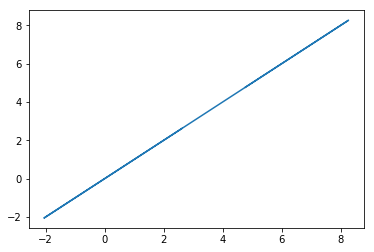

In [350]:
plt.plot(line_x, line_y)

In [355]:
f = plt.figure()    

f, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey = True, figsize=(10,10))


alphas = np.linspace(0.1, 1, len(ep_scatter))
rgba_colors = np.zeros((len(ep_scatter),4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

for col in range(ncols):
    for row in range(nrows):
        line_x = []
        line_y = []
        for i in range(len(ep_scatter)):
            line_x.append(x_scatter[i-1][row])
            line_y.append(x_scatter[i-1][col])
            
        axes[row][col].scatter(line_x, line_y, s=s_scatter[i], color=rgba_colors)
            
        axes[row][col].plot(line_x, line_y, color = rgba_colors)
        
plt.show()

<Figure size 432x288 with 0 Axes>

ValueError: Invalid RGBA argument: array([[1.        , 0.        , 0.        , 0.1       ],
       [1.        , 0.        , 0.        , 0.10452261],
       [1.        , 0.        , 0.        , 0.10904523],
       [1.        , 0.        , 0.        , 0.11356784],
       [1.        , 0.        , 0.        , 0.11809045],
       [1.        , 0.        , 0.        , 0.12261307],
       [1.        , 0.        , 0.        , 0.12713568],
       [1.        , 0.        , 0.        , 0.13165829],
       [1.        , 0.        , 0.        , 0.1361809 ],
       [1.        , 0.        , 0.        , 0.14070352],
       [1.        , 0.        , 0.        , 0.14522613],
       [1.        , 0.        , 0.        , 0.14974874],
       [1.        , 0.        , 0.        , 0.15427136],
       [1.        , 0.        , 0.        , 0.15879397],
       [1.        , 0.        , 0.        , 0.16331658],
       [1.        , 0.        , 0.        , 0.1678392 ],
       [1.        , 0.        , 0.        , 0.17236181],
       [1.        , 0.        , 0.        , 0.17688442],
       [1.        , 0.        , 0.        , 0.18140704],
       [1.        , 0.        , 0.        , 0.18592965],
       [1.        , 0.        , 0.        , 0.19045226],
       [1.        , 0.        , 0.        , 0.19497487],
       [1.        , 0.        , 0.        , 0.19949749],
       [1.        , 0.        , 0.        , 0.2040201 ],
       [1.        , 0.        , 0.        , 0.20854271],
       [1.        , 0.        , 0.        , 0.21306533],
       [1.        , 0.        , 0.        , 0.21758794],
       [1.        , 0.        , 0.        , 0.22211055],
       [1.        , 0.        , 0.        , 0.22663317],
       [1.        , 0.        , 0.        , 0.23115578],
       [1.        , 0.        , 0.        , 0.23567839],
       [1.        , 0.        , 0.        , 0.24020101],
       [1.        , 0.        , 0.        , 0.24472362],
       [1.        , 0.        , 0.        , 0.24924623],
       [1.        , 0.        , 0.        , 0.25376884],
       [1.        , 0.        , 0.        , 0.25829146],
       [1.        , 0.        , 0.        , 0.26281407],
       [1.        , 0.        , 0.        , 0.26733668],
       [1.        , 0.        , 0.        , 0.2718593 ],
       [1.        , 0.        , 0.        , 0.27638191],
       [1.        , 0.        , 0.        , 0.28090452],
       [1.        , 0.        , 0.        , 0.28542714],
       [1.        , 0.        , 0.        , 0.28994975],
       [1.        , 0.        , 0.        , 0.29447236],
       [1.        , 0.        , 0.        , 0.29899497],
       [1.        , 0.        , 0.        , 0.30351759],
       [1.        , 0.        , 0.        , 0.3080402 ],
       [1.        , 0.        , 0.        , 0.31256281],
       [1.        , 0.        , 0.        , 0.31708543],
       [1.        , 0.        , 0.        , 0.32160804],
       [1.        , 0.        , 0.        , 0.32613065],
       [1.        , 0.        , 0.        , 0.33065327],
       [1.        , 0.        , 0.        , 0.33517588],
       [1.        , 0.        , 0.        , 0.33969849],
       [1.        , 0.        , 0.        , 0.34422111],
       [1.        , 0.        , 0.        , 0.34874372],
       [1.        , 0.        , 0.        , 0.35326633],
       [1.        , 0.        , 0.        , 0.35778894],
       [1.        , 0.        , 0.        , 0.36231156],
       [1.        , 0.        , 0.        , 0.36683417],
       [1.        , 0.        , 0.        , 0.37135678],
       [1.        , 0.        , 0.        , 0.3758794 ],
       [1.        , 0.        , 0.        , 0.38040201],
       [1.        , 0.        , 0.        , 0.38492462],
       [1.        , 0.        , 0.        , 0.38944724],
       [1.        , 0.        , 0.        , 0.39396985],
       [1.        , 0.        , 0.        , 0.39849246],
       [1.        , 0.        , 0.        , 0.40301508],
       [1.        , 0.        , 0.        , 0.40753769],
       [1.        , 0.        , 0.        , 0.4120603 ],
       [1.        , 0.        , 0.        , 0.41658291],
       [1.        , 0.        , 0.        , 0.42110553],
       [1.        , 0.        , 0.        , 0.42562814],
       [1.        , 0.        , 0.        , 0.43015075],
       [1.        , 0.        , 0.        , 0.43467337],
       [1.        , 0.        , 0.        , 0.43919598],
       [1.        , 0.        , 0.        , 0.44371859],
       [1.        , 0.        , 0.        , 0.44824121],
       [1.        , 0.        , 0.        , 0.45276382],
       [1.        , 0.        , 0.        , 0.45728643],
       [1.        , 0.        , 0.        , 0.46180905],
       [1.        , 0.        , 0.        , 0.46633166],
       [1.        , 0.        , 0.        , 0.47085427],
       [1.        , 0.        , 0.        , 0.47537688],
       [1.        , 0.        , 0.        , 0.4798995 ],
       [1.        , 0.        , 0.        , 0.48442211],
       [1.        , 0.        , 0.        , 0.48894472],
       [1.        , 0.        , 0.        , 0.49346734],
       [1.        , 0.        , 0.        , 0.49798995],
       [1.        , 0.        , 0.        , 0.50251256],
       [1.        , 0.        , 0.        , 0.50703518],
       [1.        , 0.        , 0.        , 0.51155779],
       [1.        , 0.        , 0.        , 0.5160804 ],
       [1.        , 0.        , 0.        , 0.52060302],
       [1.        , 0.        , 0.        , 0.52512563],
       [1.        , 0.        , 0.        , 0.52964824],
       [1.        , 0.        , 0.        , 0.53417085],
       [1.        , 0.        , 0.        , 0.53869347],
       [1.        , 0.        , 0.        , 0.54321608],
       [1.        , 0.        , 0.        , 0.54773869],
       [1.        , 0.        , 0.        , 0.55226131],
       [1.        , 0.        , 0.        , 0.55678392],
       [1.        , 0.        , 0.        , 0.56130653],
       [1.        , 0.        , 0.        , 0.56582915],
       [1.        , 0.        , 0.        , 0.57035176],
       [1.        , 0.        , 0.        , 0.57487437],
       [1.        , 0.        , 0.        , 0.57939698],
       [1.        , 0.        , 0.        , 0.5839196 ],
       [1.        , 0.        , 0.        , 0.58844221],
       [1.        , 0.        , 0.        , 0.59296482],
       [1.        , 0.        , 0.        , 0.59748744],
       [1.        , 0.        , 0.        , 0.60201005],
       [1.        , 0.        , 0.        , 0.60653266],
       [1.        , 0.        , 0.        , 0.61105528],
       [1.        , 0.        , 0.        , 0.61557789],
       [1.        , 0.        , 0.        , 0.6201005 ],
       [1.        , 0.        , 0.        , 0.62462312],
       [1.        , 0.        , 0.        , 0.62914573],
       [1.        , 0.        , 0.        , 0.63366834],
       [1.        , 0.        , 0.        , 0.63819095],
       [1.        , 0.        , 0.        , 0.64271357],
       [1.        , 0.        , 0.        , 0.64723618],
       [1.        , 0.        , 0.        , 0.65175879],
       [1.        , 0.        , 0.        , 0.65628141],
       [1.        , 0.        , 0.        , 0.66080402],
       [1.        , 0.        , 0.        , 0.66532663],
       [1.        , 0.        , 0.        , 0.66984925],
       [1.        , 0.        , 0.        , 0.67437186],
       [1.        , 0.        , 0.        , 0.67889447],
       [1.        , 0.        , 0.        , 0.68341709],
       [1.        , 0.        , 0.        , 0.6879397 ],
       [1.        , 0.        , 0.        , 0.69246231],
       [1.        , 0.        , 0.        , 0.69698492],
       [1.        , 0.        , 0.        , 0.70150754],
       [1.        , 0.        , 0.        , 0.70603015],
       [1.        , 0.        , 0.        , 0.71055276],
       [1.        , 0.        , 0.        , 0.71507538],
       [1.        , 0.        , 0.        , 0.71959799],
       [1.        , 0.        , 0.        , 0.7241206 ],
       [1.        , 0.        , 0.        , 0.72864322],
       [1.        , 0.        , 0.        , 0.73316583],
       [1.        , 0.        , 0.        , 0.73768844],
       [1.        , 0.        , 0.        , 0.74221106],
       [1.        , 0.        , 0.        , 0.74673367],
       [1.        , 0.        , 0.        , 0.75125628],
       [1.        , 0.        , 0.        , 0.75577889],
       [1.        , 0.        , 0.        , 0.76030151],
       [1.        , 0.        , 0.        , 0.76482412],
       [1.        , 0.        , 0.        , 0.76934673],
       [1.        , 0.        , 0.        , 0.77386935],
       [1.        , 0.        , 0.        , 0.77839196],
       [1.        , 0.        , 0.        , 0.78291457],
       [1.        , 0.        , 0.        , 0.78743719],
       [1.        , 0.        , 0.        , 0.7919598 ],
       [1.        , 0.        , 0.        , 0.79648241],
       [1.        , 0.        , 0.        , 0.80100503],
       [1.        , 0.        , 0.        , 0.80552764],
       [1.        , 0.        , 0.        , 0.81005025],
       [1.        , 0.        , 0.        , 0.81457286],
       [1.        , 0.        , 0.        , 0.81909548],
       [1.        , 0.        , 0.        , 0.82361809],
       [1.        , 0.        , 0.        , 0.8281407 ],
       [1.        , 0.        , 0.        , 0.83266332],
       [1.        , 0.        , 0.        , 0.83718593],
       [1.        , 0.        , 0.        , 0.84170854],
       [1.        , 0.        , 0.        , 0.84623116],
       [1.        , 0.        , 0.        , 0.85075377],
       [1.        , 0.        , 0.        , 0.85527638],
       [1.        , 0.        , 0.        , 0.85979899],
       [1.        , 0.        , 0.        , 0.86432161],
       [1.        , 0.        , 0.        , 0.86884422],
       [1.        , 0.        , 0.        , 0.87336683],
       [1.        , 0.        , 0.        , 0.87788945],
       [1.        , 0.        , 0.        , 0.88241206],
       [1.        , 0.        , 0.        , 0.88693467],
       [1.        , 0.        , 0.        , 0.89145729],
       [1.        , 0.        , 0.        , 0.8959799 ],
       [1.        , 0.        , 0.        , 0.90050251],
       [1.        , 0.        , 0.        , 0.90502513],
       [1.        , 0.        , 0.        , 0.90954774],
       [1.        , 0.        , 0.        , 0.91407035],
       [1.        , 0.        , 0.        , 0.91859296],
       [1.        , 0.        , 0.        , 0.92311558],
       [1.        , 0.        , 0.        , 0.92763819],
       [1.        , 0.        , 0.        , 0.9321608 ],
       [1.        , 0.        , 0.        , 0.93668342],
       [1.        , 0.        , 0.        , 0.94120603],
       [1.        , 0.        , 0.        , 0.94572864],
       [1.        , 0.        , 0.        , 0.95025126],
       [1.        , 0.        , 0.        , 0.95477387],
       [1.        , 0.        , 0.        , 0.95929648],
       [1.        , 0.        , 0.        , 0.9638191 ],
       [1.        , 0.        , 0.        , 0.96834171],
       [1.        , 0.        , 0.        , 0.97286432],
       [1.        , 0.        , 0.        , 0.97738693],
       [1.        , 0.        , 0.        , 0.98190955],
       [1.        , 0.        , 0.        , 0.98643216],
       [1.        , 0.        , 0.        , 0.99095477],
       [1.        , 0.        , 0.        , 0.99547739],
       [1.        , 0.        , 0.        , 1.        ]])

<Figure size 720x720 with 9 Axes>

0 0
0 1
1 0
1 1


<Figure size 432x288 with 0 Axes>

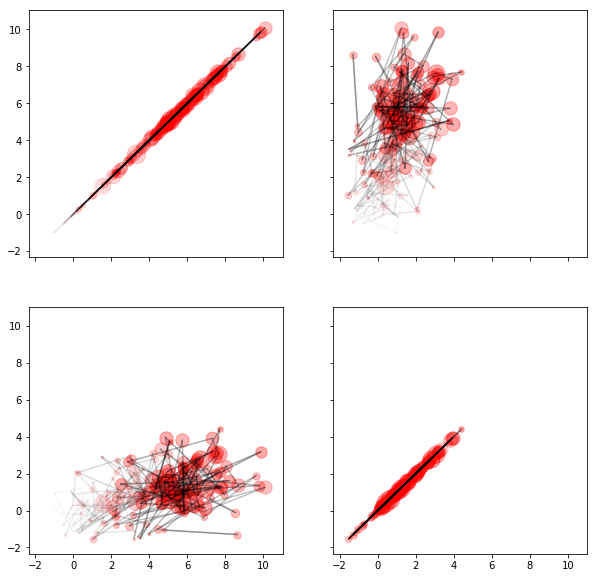

In [357]:
f = plt.figure()    

nrows = 2
ncols = 2
f, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey = True, figsize=(10,10))



for col in range(ncols):
    for row in range(nrows):
        for i in range(len(ep_scatter)):
            line_x = []
            line_y = []
            line_x.append(x_scatter[i-1][0])
            line_y.append(x_scatter[i-1][1])
        for i in range(len(ep_scatter)):
            axes[row][col].scatter(x_scatter[i][col], x_scatter[i][row],
                                   color='r', s=s_scatter[i], alpha = ep_scatter[i])
            if i < len(ep_scatter)-1:
                axes[row][col].plot([x_scatter[i-1][col]] + [x_scatter[i][col]],
                                    [x_scatter[i-1][row]] + [x_scatter[i][row]],
                                    color='black', alpha=0.4*i/len(ep_scatter))
            axes[row][col].plot(line_x, line_y, color='black', alpha=0.4*i/len(ep_scatter))
            
        print(col, row)
plt.show()

In [ ]:
type(recommendation)

In [73]:
print(recommendation)

(0.7408146354361135, 0.5331237899686446)


In [363]:
ifunc(recommendation)

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 34s 17ms/step - loss: 1.7717 - acc: 0.4660 - val_loss: 1.4153 - val_acc: 0.6330
Epoch 2/10
2000/2000 [==============================] - 0s 158us/step - loss: 1.1038 - acc: 0.7135 - val_loss: 1.0279 - val_acc: 0.7070
Epoch 3/10
2000/2000 [==============================] - 0s 157us/step - loss: 0.8090 - acc: 0.7800 - val_loss: 0.8314 - val_acc: 0.7730
Epoch 4/10
2000/2000 [==============================] - 0s 162us/step - loss: 0.6462 - acc: 0.8100 - val_loss: 0.7143 - val_acc: 0.8090
Epoch 5/10
2000/2000 [==============================] - 0s 156us/step - loss: 0.5515 - acc: 0.8450 - val_loss: 0.6540 - val_acc: 0.8180
Epoch 6/10
2000/2000 [==============================] - 0s 154us/step - loss: 0.4789 - acc: 0.8700 - val_loss: 0.6028 - val_acc: 0.8340
Epoch 7/10
2000/2000 [==============================] - 0s 155us/step - loss: 0.4295 - acc: 0.8775 - val_loss: 0.5693 - val_acc: 0.8430


0.5390435092449188

In [362]:
args, kwargs = ifunc.convert_to_arguments(recommendation)
print(args[4:])     # skip the data we feed
print(kwargs)  

print(ifunc.get_summary(recommendation))

(20, 30, 0.2, True, 80, 'elu')
OrderedDict()
 - arg #5: Value 20, from data: 5.0745603581766865
 - arg #6: Value 30, from data: 0.6408475230502724
 - arg #7: Value 0.2, from data: -1.919149735907273
 - arg #8: Value True, from data: [-5.43384245  1.72107825] yielding probas: "False": 0.0%, "True": 100.0%
 - arg #9: Value 80, from data: 1.883666386473878
 - arg #10: Value elu, from data: [-0.82955412  3.46519729] yielding probas: "relu": 1.0%, "elu": 99.0%


In [ ]:
# Based on that we should make our network bigger, but that will be in the next chapter